In [2]:
import sys
sys.path.append("../")
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import pickle

### Preparation of data set

In [3]:
import numpy as np
import scipy as sp
import tensorflow as tf
from matplotlib import pyplot as plt

np.random.seed(15)
tf.random.set_seed(15)

def high(x):
    '''
    High-fidelity function
    '''
    x0 = x[...,0]
    x1 = x[...,1]
    r = np.sqrt(x0**2+x1**2)
    return sp.special.j0(r)

def low(x):
    '''
    Low-fidelity function
    '''
    x0 = x[...,0]
    x1 = x[...,1]
    r = np.sqrt(x0**2+x1**2)
    return (1-r**2/4)/(1+r**4)+np.sqrt(2/(np.pi*np.abs(r)))*r**4/(1+r**4)

def scale_range(x,ub,lb):
    Np = x.shape[0]
    dim = x.shape[1]
    for i in range(0,Np):
        for j in range(0,dim):
            tmp = ub[j] -lb[j]
            x[i][j] = tmp*x[i][j] + lb[j]
    return x

def rmse(pred, truth):
    pred = pred.flatten()
    truth = truth.flatten()
    return np.sqrt(np.mean((pred-truth)**2))


df = pd.read_csv("low_fidelity_data.csv")
data_low_x = df[["x0","x1"]].to_numpy()
data_low_y = df["y_low"].to_numpy()[:,np.newaxis]

df = pd.read_csv("high_fidelity_data.csv")
data_high_x = df[["x0","x1"]].to_numpy()
data_high_y = df["y_high"].to_numpy()[:,np.newaxis]
print(data_low_x.shape, data_low_y.shape)
print(data_high_x.shape, data_high_y.shape)

(512, 2) (512, 1)
(196, 2) (196, 1)


In [4]:
# Load pickels of optimized models
with open("model_singleGP_RBF.pkl","rb") as f:
    model_singleGP_RBF = pickle.load(f)
with open("model_singleGP_NKN.pkl","rb") as f:
    model_singleGP_NKN = pickle.load(f)
with open("model_NARGP_RBF.pkl","rb") as f:
    model_NARGP_RBF = pickle.load(f)
with open("model_NARGP_NKN.pkl","rb") as f:
    model_NARGP_NKN = pickle.load(f)

x0 = np.linspace(-8,8,30)
x1 = np.linspace(-8,8,30)
x0m, x1m = np.meshgrid(x0,x1)
xm = np.stack([x0m,x1m],axis=-1)
mean_list = []
var_list = []
mean, var = model_singleGP_RBF.predict(xm.reshape(xm.size//2,2)); mean_list.append(mean[:,0].reshape(x0m.shape)); var_list.append(var[:,0].reshape(x0m.shape))
mean, var = model_singleGP_NKN.predict(xm.reshape(xm.size//2,2)); mean_list.append(mean[:,0].reshape(x0m.shape)); var_list.append(var[:,0].reshape(x0m.shape))
mean, var = model_NARGP_RBF.predict(xm.reshape(xm.size//2,2)); mean_list.append(mean[:,0].reshape(x0m.shape)); var_list.append(var[:,0].reshape(x0m.shape))
mean, var = model_NARGP_NKN.predict(xm.reshape(xm.size//2,2)); mean_list.append(mean[:,0].reshape(x0m.shape)); var_list.append(var[:,0].reshape(x0m.shape))
label_list = [r"Single GP(RBF)", 
              r"Single GP(NKN)",
              r"NARGP(RBF)", 
              r"NARGP(NKN)"]

/home/maeyama/mylib/Miniforge3/envs/dps_3.12.11/lib/python3.12/site-packages/gpflow/versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-09-26 10:22:59.535376: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


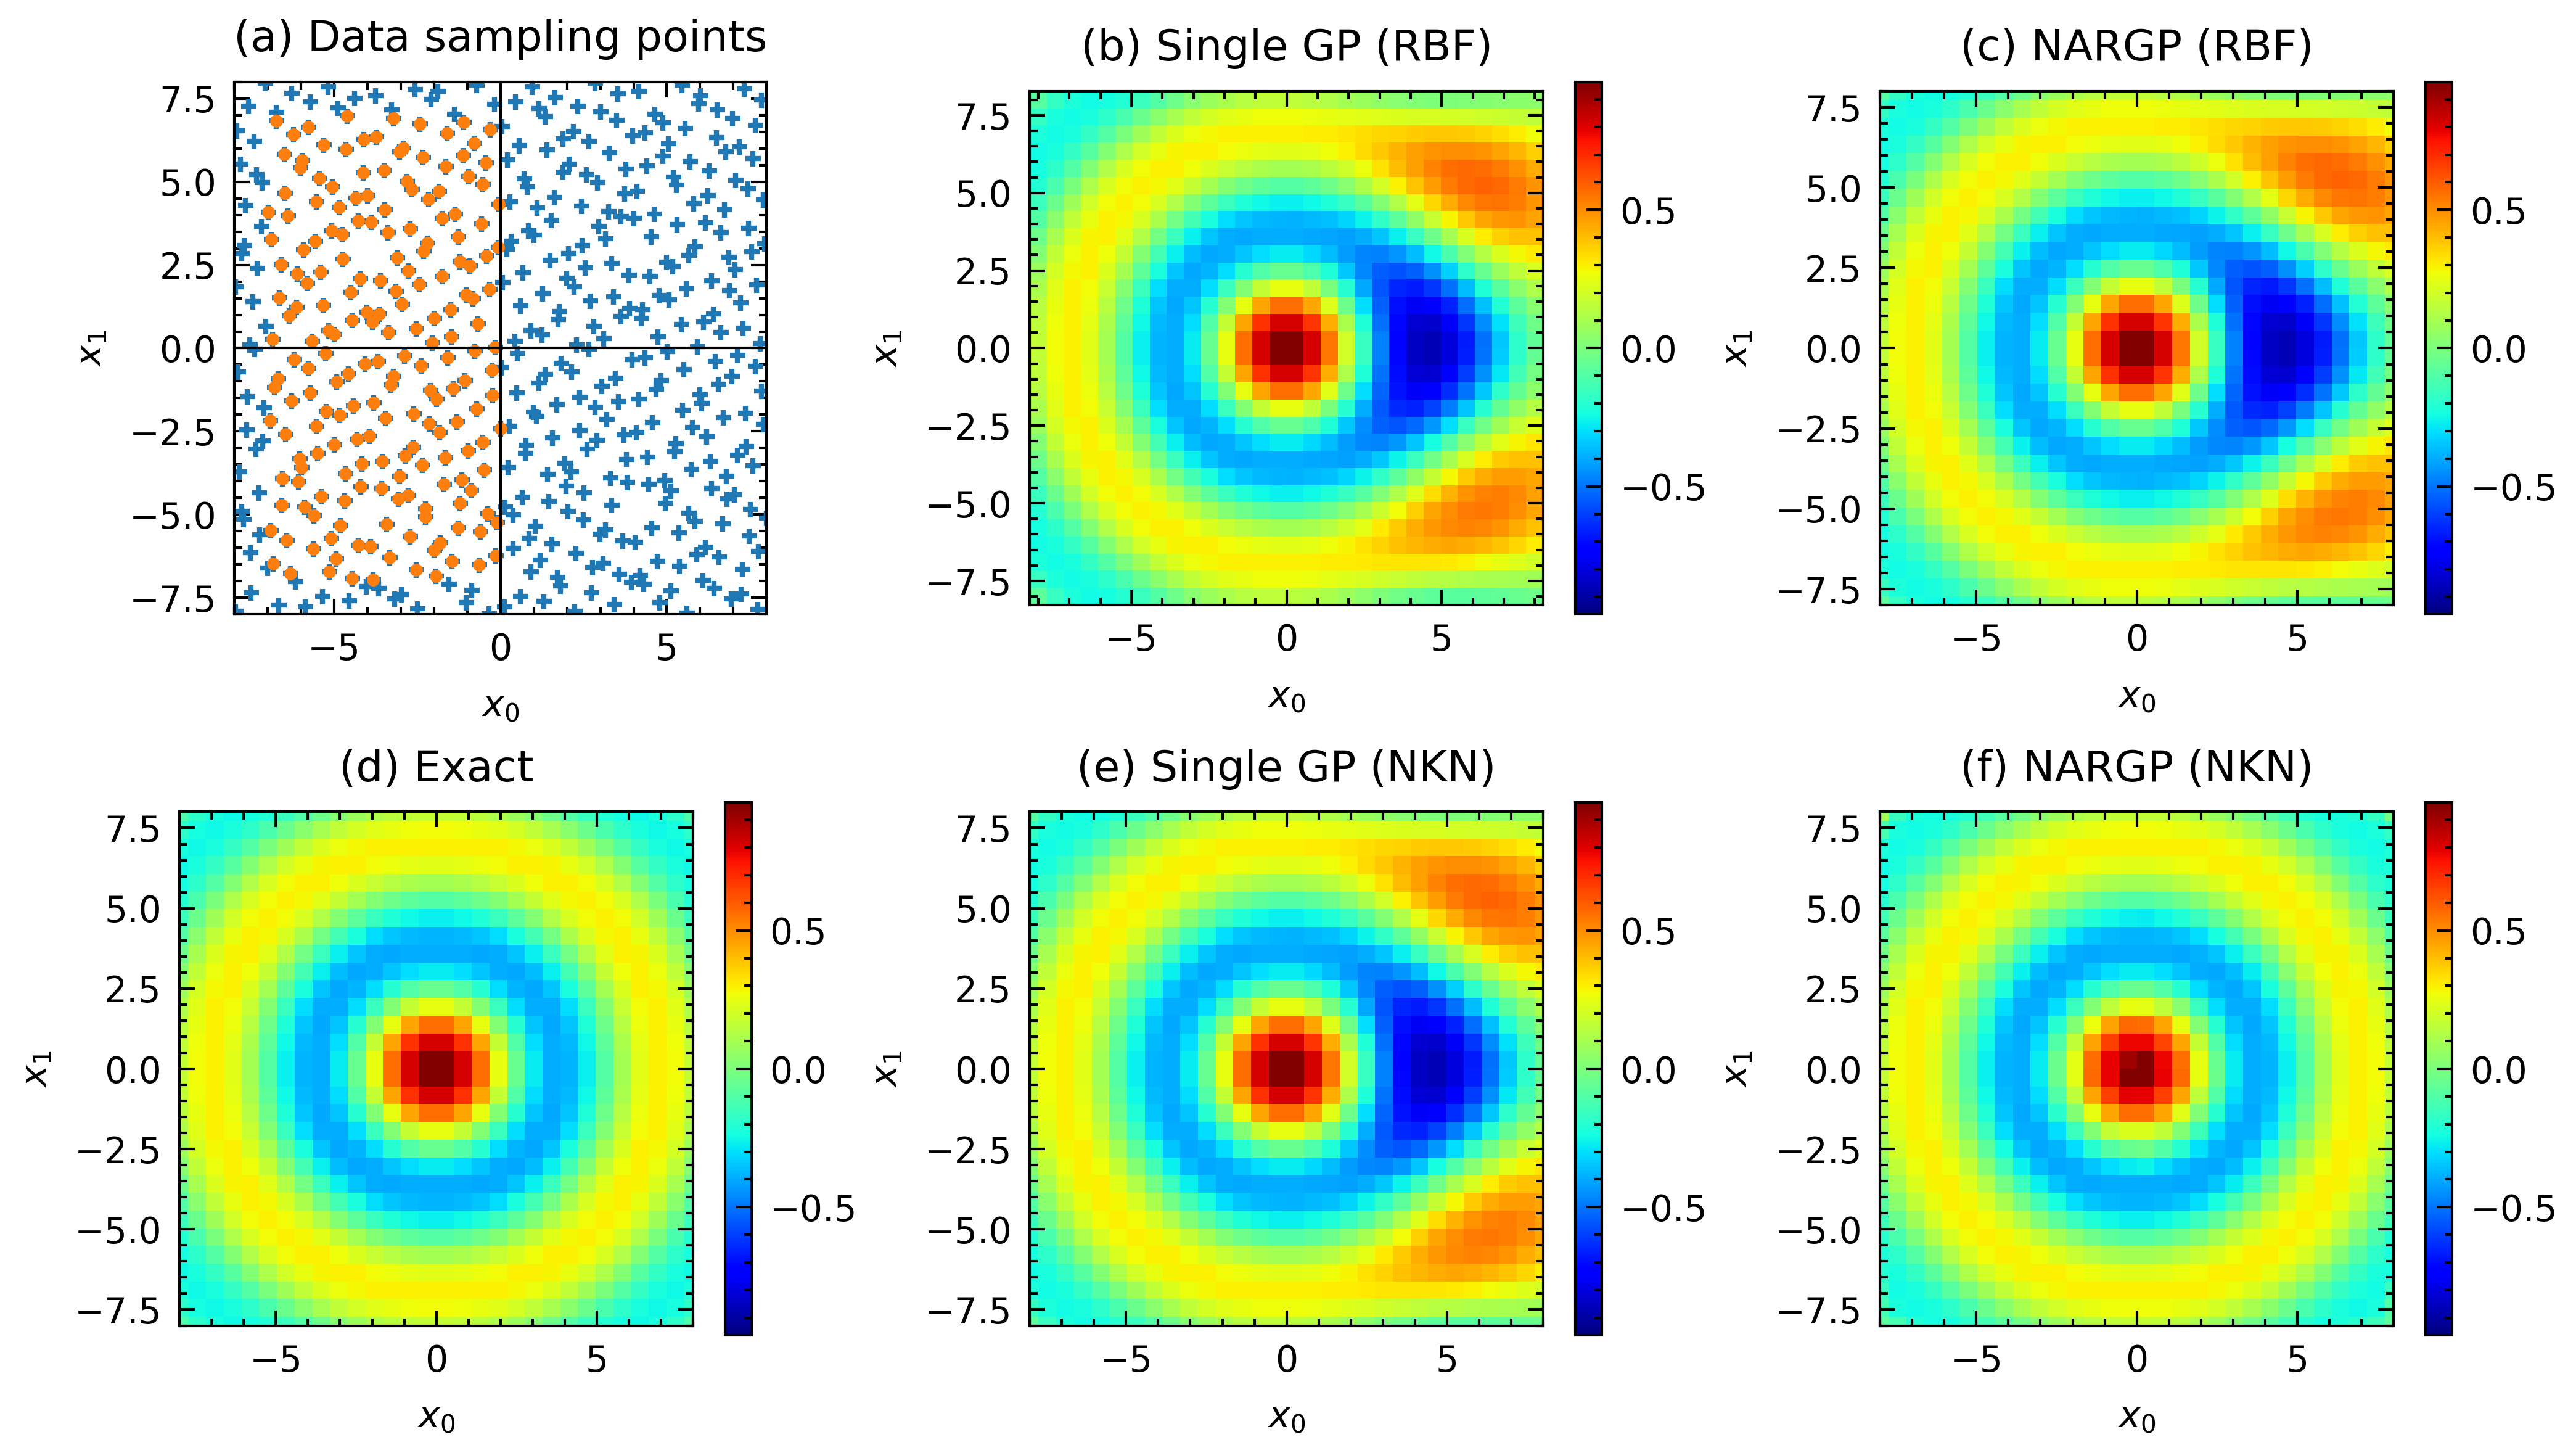

In [6]:
plt.style.use('../nature_style.txt')

vmax = high(xm).max()
vmin = high(xm).min()
fig = plt.figure(figsize=(7,4), dpi=600)
ax = fig.add_subplot(231)
ax.plot(data_low_x[:,0],data_low_x[:,1],"+",label="Low-fid.\ndata")
ax.plot(data_high_x[:,0],data_high_x[:,1],".",label="High-fid.\ndata")
ax.axhline(0,lw=0.5,c="k")
ax.axvline(0,lw=0.5,c="k")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_aspect('equal')
ax.set_title("(a) Data sampling points")#, fontfamily="sans-serif", fontweight="bold", fontsize=8, transform=ax.transAxes)

# ax.legend(loc="center left", bbox_to_anchor=(0.8,0.5))

ax = fig.add_subplot(232)
quad = ax.pcolormesh(x0m,x1m,mean_list[0],cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("(b) Single GP (RBF)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
ax.set_aspect('equal')
fig.colorbar(quad)

ax = fig.add_subplot(233)
quad = ax.pcolormesh(x0m,x1m,mean_list[1],cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("(c) NARGP (RBF)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_aspect('equal')
fig.colorbar(quad)

ax = fig.add_subplot(234)
quad = ax.pcolormesh(x0m,x1m,high(xm),cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("(d) Exact")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_aspect('equal')
fig.colorbar(quad)

ax = fig.add_subplot(235)
quad = ax.pcolormesh(x0m,x1m,mean_list[2],cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("(e) Single GP (NKN)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_aspect('equal')
fig.colorbar(quad)

ax = fig.add_subplot(236)
quad = ax.pcolormesh(x0m,x1m,mean_list[3],cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("(f) NARGP (NKN)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_aspect('equal')
fig.colorbar(quad)

fig.tight_layout()
plt.savefig("fig3.pdf",dpi=600,bbox_inches="tight")
plt.show()

Single GP (RBF)
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 23.66116                │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1.74539    0.87329583] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        